In [123]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
from collections import defaultdict
from IPython.display import set_matplotlib_formats
from bs4 import BeautifulSoup
set_matplotlib_formats('png','pdf')


In [124]:
folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100', 'brands-data-it2', 'jbt-data-it2', 'compsci-data-it2']
MERGE_OTHER = True
ut = 'brands'
folder = ['brands-data-it2', 'brands-data-it3', 'brands-data-400', 'brands-data-100']
#folder = ['{}-data'.format(ut), '{}-data-it2'.format(ut)]

In [125]:


agg_list = []
full_list = []
test_list = []
for f in folder:
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    test = pd.read_csv('{}/test.csv'.format(f))

    test = test[test['_hidden'] == False]
    print('{} {}'.format(f,len(test)))
    test['type'] = f.split('-')[0]
    test.set_index('id')
    
    test_list.append (test)
aggregated = pd.concat(agg_list)
if MERGE_OTHER:
    aggregated['label'] = aggregated.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)
    full['label'] = full.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)


print(aggregated.describe())
full = pd.concat(full_list)
test_questions = pd.concat(test_list)

aggregated = aggregated[aggregated['_unit_state'] == 'finalized']
aggregated['raw_text'] = aggregated.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)


def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', '_golden', 'label_r', '_trust','a','b']].sort_values(['label:confidence', 'label_l' ,'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned_by_crowdflower', 'label_r' : 'proposed_by_annotator'})
    renamed_avg
    return renamed_avg


brands-data-it2 60
brands-data-it3 75
brands-data-400 67
brands-data-100 75
       _trusted_judgments      _unit_id  label:confidence  label_gold  \
count         2606.000000  2.606000e+03       2606.000000         0.0   
mean             3.020721  1.562485e+09          0.897273         NaN   
std              0.357471  2.161838e+07          0.168929         NaN   
min              1.000000  1.530058e+09          0.335800         NaN   
25%              3.000000  1.532715e+09          0.698125         NaN   
50%              3.000000  1.572198e+09          1.000000         NaN   
75%              3.000000  1.572199e+09          1.000000         NaN   
max              5.000000  1.622486e+09          1.000000         NaN   

       label_gold_reason  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN  


In [126]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(aggregated,stratify=aggregated['label'], test_size=0.2)
print('{} {}'.format(len(train_i), len(test_i)))
print(train_i['_golden'].unique())
print(test_i['_golden'].unique())

2075 519
[False]
[False]


In [131]:
to_remove = test_questions['id'].unique()
print(aggregated.columns)
aggregated = aggregated[~aggregated['id'].isin( to_remove)][['id', 'a', 'b', 'raw_text', 'text_html', 'text_readable', 'type', 'marker']]
aggregated['label_gold'] = ''
aggregated['label_gold_reason'] = ''
aggregated['_golden'] = False
aggregated.to_csv('{}-sentences.csv'.format(ut), index=False)
len(aggregated['id'].unique())

Index(['id', 'a', 'b', 'raw_text', 'text_html', 'text_readable', 'type',
       'marker', 'label_gold', 'label_gold_reason', '_golden'],
      dtype='object')


2422

In [127]:
testq = test_questions.drop_duplicates(subset=['id'])[['id', 'label_gold', 'text_html', 'text_readable', 'marker', 'a', 'b', 'raw_text', 'type', 'label_gold_reason']]
testq['label_gold'] = testq.apply(lambda row: testq['label_gold'].str.replace('OTHER\n', ''), axis=0)
testq['_golden'] = True
testq.to_csv('{}-test-questions.csv'.format(ut), index=False)
testq

,id,label_gold,text_html,text_readable,marker,a,b,raw_text,type,label_gold_reason,_golden
0,H1216379431,NONE,"I'm sorry, Sony's going to have to do better o...","I'm sorry, Sony's going to have to do better o...",True,IBM,Dell,Here you get a quad-core 2.2GHz Intel Core i7 ...,brands,Sony is compared to the two objects of interest.,True
2,I1317900497,NONE,"In this IT Briefing, <span style=""color: #9A14...","In this IT Briefing, *Intel* and §IBM$ systems...",True,IBM,Intel,small Google satellite map of N. Kingston/quon...,brands,NaN,True
3,B334288391,NONE,"Are deadly strikes at Cambodia's <span style=""...","Are deadly strikes at Cambodia's *Nike*, Puma ...",True,Nike,Adidas,It's just Apple trying to get better terms/ser...,brands,NaN,True
4,I1295499877,NONE,"<span style=""color: #9A14B2; font-weight: bold...",*Intel* reported better-than-expected earnings...,True,Microsoft,Intel,He better hope so considering the commitment t...,brands,Intel and Microsoft are not compared against e...,True
5,O2375114608,NONE,"That's better than <span style=""color: #9A14B2...","That's better than *Ford* Fusion Hybrid, §Chev...",True,Ford,Chevrolet,"If you choose tho adapt manual lenses, like Ni...",brands,Ford and Chevrolet are not compared against ea...,True
6,M2058434090,NONE,"Quick reminder here: Both <span style=""color: ...",Quick reminder here: Both *IBM* and §Microsoft...,True,Microsoft,IBM,"Where is Nokia, Ericsson, and Motorola now?",brands,NaN,True
7,O2434821235,NONE,The chip is expected to provide faster perform...,The chip is expected to provide faster perform...,True,Dell,Hewlett-Packard,"Ive never had better (and Ive owned BMW, SaaB,...",brands,"""The chip"" is compared to the Atom Clover Trai...",True
8,Q2733431130,WORSE,The tech blogs are saying that in real-world e...,The tech blogs are saying that in real-world e...,True,Samsung,Toshiba,The tech blogs are saying that in real-world e...,brands,Toshiba drives are slower than Samsung Drives,True
9,E676524787,WORSE\nNONE,"Every major auto maker, whether failing or not...","Every major auto maker, whether failing or not...",True,Toyota,Chrysler,"Every major auto maker, whether failing or not...",brands,Chrysler has a bigger loss in sales (48%) than...,True
11,L1774002505,WORSE\nNONE,"My personal thoughts of <span style=""color: #9...",My personal thoughts of *Dell* are they are no...,True,Sony,Dell,My personal thoughts of Dell are they are not ...,brands,It is not quite clear if the author wants to s...,True


### Quality

In [73]:
conf = aggregated[['id','text_html', 'text_readable', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
display(conf[['id', 'text_html']].describe())

,label:confidence
count,2422.000000
mean,0.896942
std,0.169127
min,0.335800
25%,0.696250
50%,1.000000
75%,1.000000
max,1.000000


,id,text_html
count,2422,2422
unique,2422,2422
top,H1131365660,"Although <span style=""color: #9A14B2; font-wei..."
freq,1,1


Sentences with a confidence <= 0.6. Either all three annotators gave a different answer or the annotators are not trustworthy enough.

In [74]:
import re
from collections import defaultdict
from pprint import pprint
import operator
d = defaultdict(int)
exp = r'[\w\s+*-]+(?=:\[OBJECT_[AB]\])'
s = set()
for i, row in aggregated.iterrows():
    a = (sorted(re.findall(exp, row['text_html'])))
    d['{} vs. {}'.format(a[0],a[1])] += 1
print(len(d))
pprint(sorted(d.items(), key=operator.itemgetter(1)))

63
[('Hewlett-Packard vs. IBM', 11),
 ('Avaya vs. Huawei', 20),
 ('Cadillac vs. Lexus', 22),
 ('Advil vs. Ibuprofen', 24),
 ('Amazon vs. Sony', 25),
 ('Intel vs. Sony', 26),
 ('Coca-Cola vs. Pepsi', 26),
 ('Nokia vs. Siemens', 26),
 ('MSI vs. Nvidia', 27),
 ('Google vs. IBM', 28),
 ('Dell vs. Sony', 28),
 ('Dell vs. Hewlett-Packard', 29),
 ('Chevrolet vs. Toyota', 29),
 ('Dell vs. Microsoft', 31),
 ('IBM vs. Microsoft', 31),
 ('Intel vs. Microsoft', 32),
 ('Apple vs. IBM', 32),
 ('Chrysler vs. Toyota', 33),
 ('Hewlett-Packard vs. Intel', 33),
 ('Amazon vs. Google', 33),
 ('Apple vs. Dell', 34),
 ('AMD vs. Samsung', 34),
 ('Intel vs. Kingston', 35),
 ('Amazon vs. Microsoft', 36),
 ('Apple vs. Microsoft', 36),
 ('Chrysler vs. Ford', 36),
 ('Ferrari vs. Renault', 38),
 ('Dell vs. IBM', 38),
 ('Ford vs. Honda', 39),
 ('Buick vs. Cadillac', 39),
 ('Motorola vs. Nokia', 39),
 ('Apple vs. Google', 40),
 ('BMW vs. Toyota', 41),
 ('Amazon vs. Apple', 41),
 ('Ford vs. Nissan', 42),
 ('Audi vs. M

### All Sentences

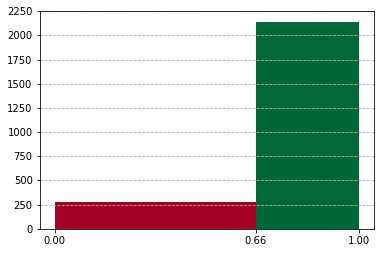

In [75]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.0,  0.66, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

## Results

**Label Distribution**

In [76]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

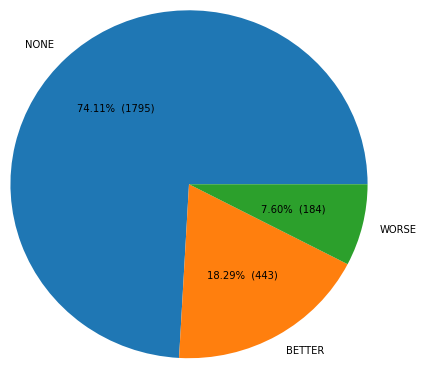

In [77]:
show_dist(aggregated['label'])